In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import simple_icd_10 as icd
from tqdm import tqdm

In [2]:
df = pd.read_csv("icd10_categories_descriptions.csv", index_col=0)

In [3]:
df

,icd10_category,description
0,K76,Other diseases of liver
1,R18,Ascites
2,K74,Fibrosis and cirrhosis of liver
3,B19,Unspecified viral hepatitis
4,J44,Other chronic obstructive pulmonary disease
...,...,...
1752,W85,Exposure to electric transmission lines
1753,P07,Disorders related to short gestation and low b...
1754,A27,Leptospirosis
1755,Y64,Contaminated medical or biological substances


In [3]:
icd_codes = [
    f"{row.icd10_category}: {row.description}"
    for _, row in df.iterrows()
]

In [4]:
import openai

In [5]:
YANDEX_CLOUD_FOLDER = ""
YANDEX_CLOUD_API_KEY = ""
MODEL_NAME = f"gpt://{YANDEX_CLOUD_FOLDER}/qwen3-235b-a22b-fp8/latest"

client = openai.OpenAI(
    api_key=YANDEX_CLOUD_API_KEY,
    base_url="https://llm.api.cloud.yandex.net/v1"
)

In [19]:
json_schema = {
    "type": "object",
    "properties": {
        "base_icd_code": {"type": "string", "description": "Original ICD-10 code"},
        "similar_codes": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "code": {"type": "string", "description": "Similar ICD-10 код"},
                    "reason": {"type": "string", "description": "Short explanation"},
                    "similarity": {"type": "number", "description": "Similarity (0-1)"},
                },
                "required": ["code", "reason", "similarity"]
            }
        }
    },
    "required": ["base_icd_code", "similar_codes"]
}

In [22]:
response = client.chat.completions.create(
    model=f"gpt://{YANDEX_CLOUD_FOLDER}/yandexgpt/rc",
    messages=[
        {"role":"system", "content" : '''I'll give you ICD-10 categories (for example, C25, NOT C25.0!) and thier descriptions. You have to tell me, If a patient has an ICD code for a given category in their medical record, what other categories of codes are also likely to be in their medical record?
         For each similar code, provide:
– the ICD-10 code (3-character level),
– a short explanation of the similarity,
– and a similarity score between 0 and 1.'''},
            {"role": "user", "content": "E11 (Type 2 diabetes mellitus)"}
    ],
    max_tokens=700,
    temperature=0.3,
    stream=False,
    response_format={"type": "json_schema", "json_schema": json_schema}
)

In [28]:
reponses = []
for code in tqdm(icd_codes):
    response = client.chat.completions.create(
    model=f"gpt://{YANDEX_CLOUD_FOLDER}/yandexgpt/rc",
    messages=[
        {"role":"system", "content" : '''I'll give you ICD-10 categories (for example, C25, NOT C25.0!) and thier descriptions. You have to tell me, If a patient has an ICD code for a given category in their medical record, what other categories of codes are also likely to be in their medical record?
         For each similar code, provide:
– the ICD-10 code (3-character level),
– a short explanation of the similarity,
– and a similarity score between 0 and 1.'''},
            {"role": "user", "content": code}
    ],
    max_tokens=700,
    temperature=0.3,
    stream=False,
    response_format={"type": "json_schema", "json_schema": json_schema}
    )
    reponses.append(response.choices[0].message.content)

100%|██████████| 1696/1696 [1:30:48<00:00,  3.21s/it]


In [31]:
reponses[0]

'{"base_icd_code": "K76", "similar_codes": [{"code": "K70", "reason": "K70 refers to alcoholic liver disease, which is a specific type of liver disease that could be included in the broader category of other diseases of the liver (K76).", "similarity": 0.8}, {"code": "K71", "reason": "K71 refers to toxic liver disease, which is another specific type of liver disease that could be included in the broader category of other diseases of the liver (K76).", "similarity": 0.75}, {"code": "K73", "reason": "K73 refers to chronic hepatitis, which is an inflammatory liver disease and could be related to other diseases of the liver (K76).", "similarity": 0.65}, {"code": "K74", "reason": "K74 refers to fibrosis and cirrhosis of the liver, which are conditions that can result from various liver diseases and could be related to other diseases of the liver (K76).", "similarity": 0.55}]}'

In [51]:
similarity = pd.DataFrame()
for i, response in enumerate(reponses):
    if "base_icd_code" not in response:
        continue
    data = json.loads(response)
    table = pd.DataFrame(data['similar_codes'])
    if table.empty:
        continue
    table['base_icd_code'] = data['base_icd_code']

    table = table[['base_icd_code', 'code', 'reason', 'similarity']]
    
    similarity = pd.concat([similarity, table])

In [53]:
similarity.to_csv("yandex_prompt.csv")

In [4]:
similarity = pd.read_csv("yandex_prompt.csv", index_col=0)

In [5]:
similarity["base_icd_code"] = similarity["base_icd_code"].str[:3]
similarity["code"] = similarity["code"].str[:3]

In [6]:
codes = sorted(set(similarity["base_icd_code"]).union(similarity["code"]))
len(codes)

1863

In [7]:
categories = sorted(df["icd10_category"].unique())

filtered = similarity[
    similarity["base_icd_code"].isin(categories) & similarity["code"].isin(categories)
].copy()

code_to_idx = {code: idx for idx, code in enumerate(categories)}
matrix = np.zeros((len(categories), len(categories)))

for _, row in filtered.iterrows():
    i = code_to_idx[row["base_icd_code"]]
    j = code_to_idx[row["code"]]
    matrix[i, j] = row["similarity"]
    matrix[j, i] = row["similarity"] 

np.fill_diagonal(matrix, 1.0)

sim_df = pd.DataFrame(matrix, index=categories, columns=categories)

In [8]:
sorted_codes = sorted(sim_df.index)

sorted_similarity = sim_df.loc[sorted_codes, sorted_codes]

        code_i code_j  value
1471301    M34    M36    1.0
2027917    R47    R49    1.0
57699      A48    A49    1.0
2284366    T20    X11    1.0
207037     B79    B83    1.0
1467909    M32    M36    1.0
1546750    M96    Z98    1.0
2774596    Z21    Z22    1.0
1639304    N72    N74    1.0
312295     C53    D06    1.0
1676642    N96    O02    1.0
494708     D69    R20    1.0
1646091    N76    N77    1.0
1680681    N98    Z31    1.0
842470     G82    S14    1.0
940141     H70    H73    1.0
1274449    K65    K67    1.0
931655     H65    H67    1.0
938446     H69    H74    1.0
1581605    N20    N21    1.0


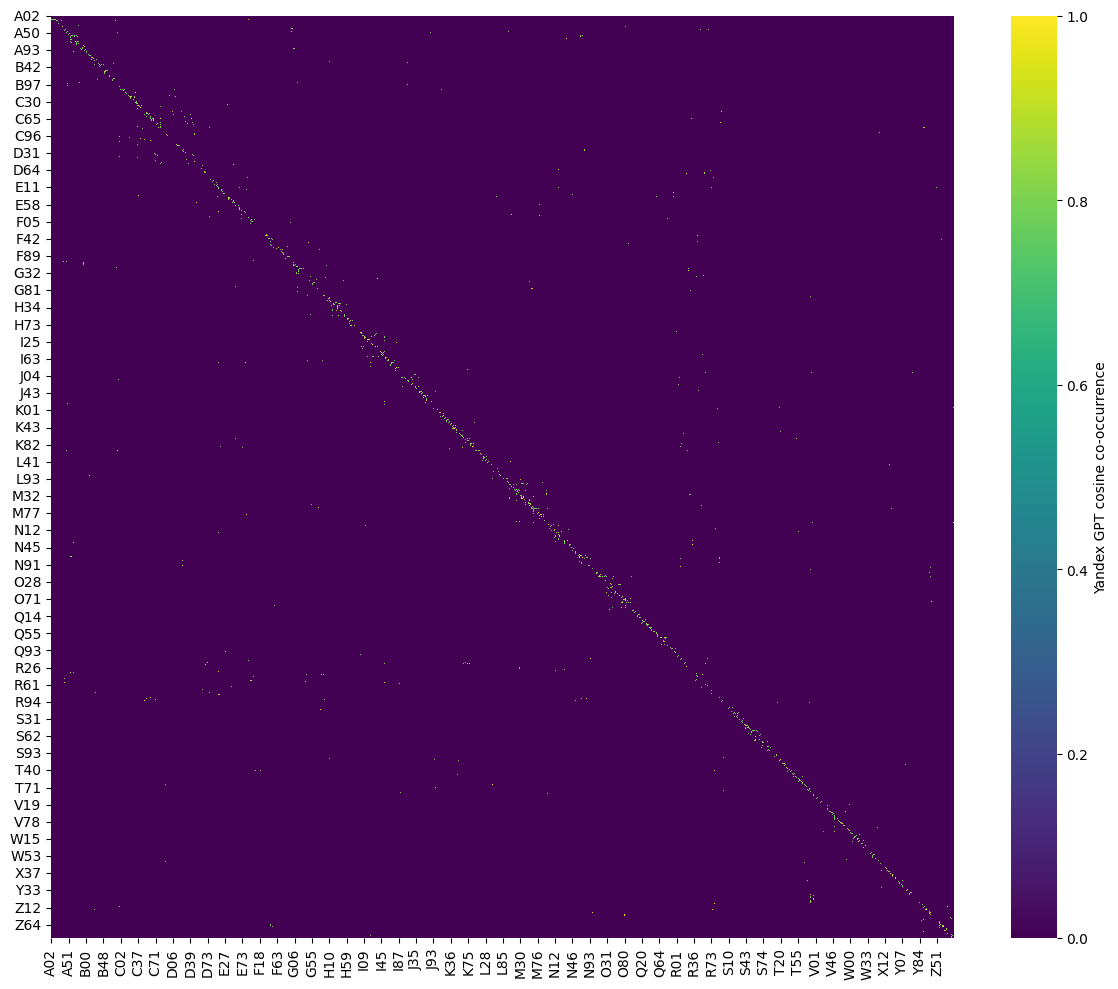

In [12]:
medbert_df = sorted_similarity

TOP_N = 1757  

long_df = medbert_df.stack().reset_index()
long_df.columns = ['code_i', 'code_j', 'value']

long_df = long_df[long_df['code_i'] < long_df['code_j']]

top_pairs_medbert = long_df.sort_values(by='value', ascending=False).head(TOP_N)
top_pairs_medbert.to_csv(f"matrix/all_medbert_pairs_{TOP_N}.csv", index=False)
print(top_pairs_medbert.iloc[0:20])

top_codes = sorted(set(top_pairs_medbert['code_i']) | set(top_pairs_medbert['code_j']))  

heatmap_matrix = pd.DataFrame(
    data=0.0,
    index=top_codes,
    columns=top_codes
)

for _, row in top_pairs_medbert.iterrows():
    i, j, value = row['code_i'], row['code_j'], row['value']
    heatmap_matrix.loc[i, j] = value
    heatmap_matrix.loc[j, i] = value

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_matrix,
    cmap="viridis",
    annot=False,
    cbar_kws={"label": "Yandex GPT cosine co-occurrence"}
)
plt.savefig(f'yandex_gpt_all.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [9]:
sorted_similarity.to_csv("yandex_prompt_matrix.csv")

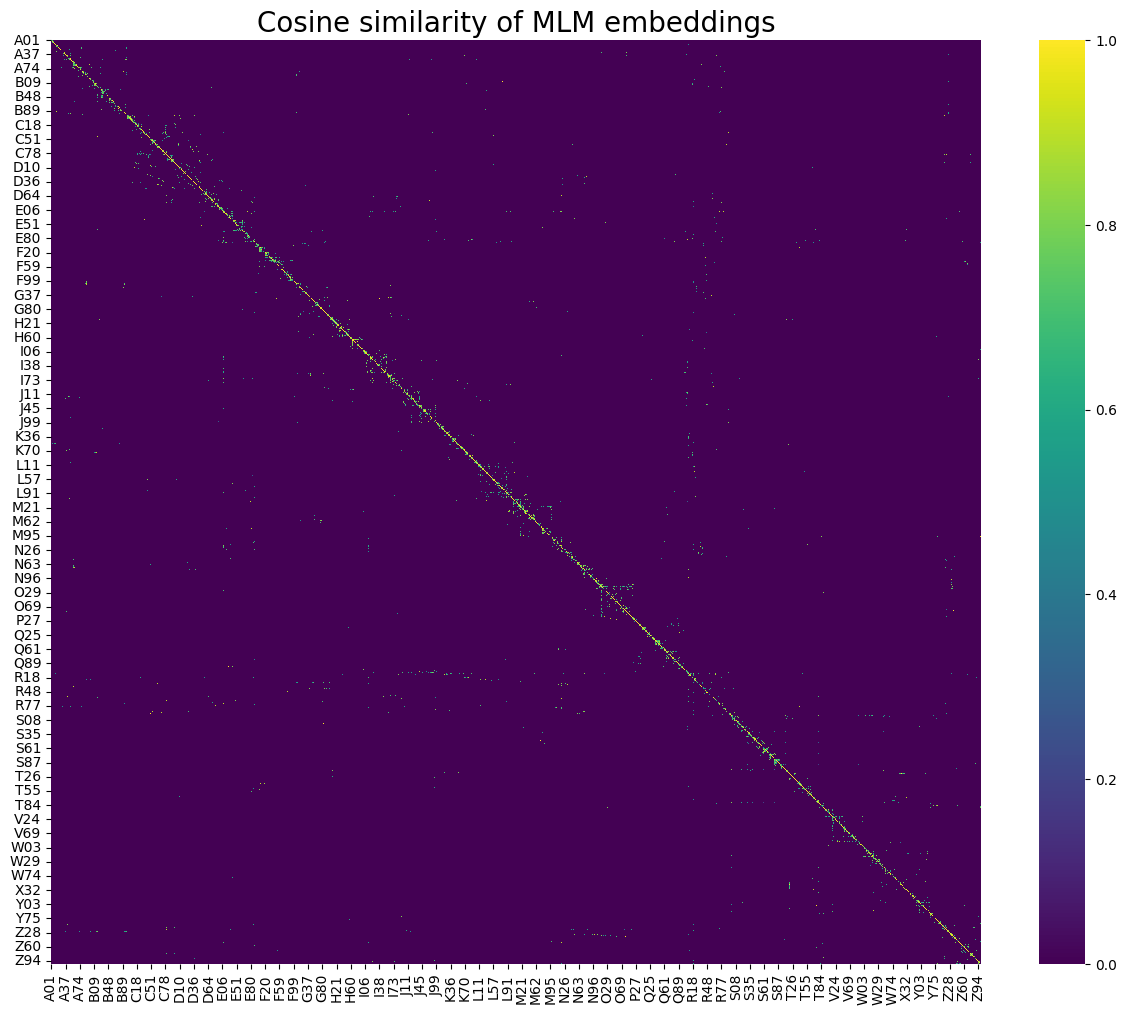

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

name = "Cosine similarity of MLM embeddings"

plt.figure(figsize=(15,12))
sns.heatmap(sorted_similarity, annot=False, cmap="viridis")
plt.title(name, fontsize=20)
plt.savefig(f'llm.jpg', dpi=300, bbox_inches='tight')